In [1]:
"""This code takes some time to run due to the high number of sampled data points
Decrease T = 1000000 for quicker but less accurate empirical PDF
or reduce the number of points evaluated in the grid increasing the skip in minmax
from 5 e.g. to 10"""

#importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

#getting current directory
import os
cwd = os.getcwd()

#importing all the functions contained in "functions.py"
%run ../functions

In [2]:
#time lengths
delta_t = 0.3 
T = 100000

#define parameters of the six-state model
V = np.array([2000, -1500, 0, 0, 0, 0])
Lambda = np.array([1, 0.5, 0.3, 2, 2.2, 1.8])
P = np.array([[0.0, 0.0, 0.0, 0.2, 0.8, 0.0],
              [0.0, 0.0, 0.0, 0.2, 0.0, 0.8],
              [0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
              [0.6, 0.4, 0.0, 0.0, 0.0, 0.0],
              [0.8, 0.0, 0.2, 0.0, 0.0, 0.0],
              [0.0, 0.8, 0.2, 0.0, 0.0, 0.0]])
sigma = 50
n = Lambda.shape[0]

#running the model
x_sim, y_sim, t_sim, sw, st = n_state_model(delta_t, T, V, Lambda, P, sigma)

#constructing the increments
delta_y = np.array([y_sim[i]-y_sim[i-1] for i in range(1, len(y_sim))])

In [3]:
#define points for which we need the PDF approximation  
minmax = np.arange(int(np.min(delta_y)), int(np.max(delta_y)+1), 5)
X, Y = np.meshgrid(minmax, minmax)

#computing the approximate PDF for independent case P1(Delta y_1)P1(Delta y_2)
approx_pdf_ind_semires = np.array([approx_pdf_up_to_1_switch(V, Lambda, P, sigma,
                                                             delta_t, x)
                                   for x in X])
approx_pdf_ind_res = np.multiply(approx_pdf_ind_semires.T, approx_pdf_ind_semires)

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V, Lambda,
                                                                          P, sigma,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

In [4]:
#compute the kernel density
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([delta_y[1:], delta_y[0:-1]])

#compute the kernel density
kde = KernelDensity(bandwidth=25.0, kernel='gaussian')
kde.fit(values.T)

# score_samples returns the log of the PDF
logPDF = kde.score_samples(positions.T)
track_PDF = np.exp(logPDF)
track_PDF = np.reshape(track_PDF.T, X.shape)

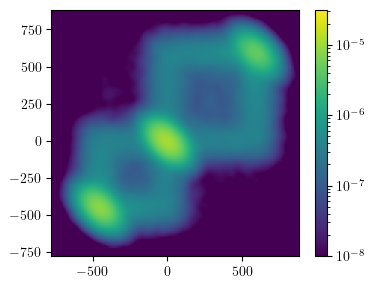

In [5]:
#check the approximation
plt.figure(figsize=(4,3.2))

pcm = plt.pcolor(X, Y, track_PDF,
                 norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)))

plt.colorbar(pcm)

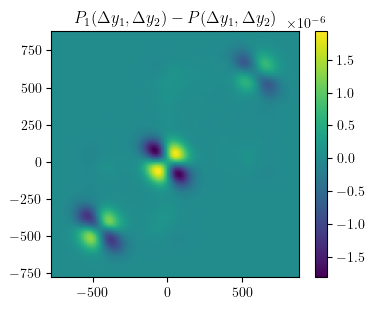

In [10]:
#plot the error of the joint P_1
fig = plt.figure(figsize=(4,3.2))
ax = fig.add_subplot(111)

plt.title('$P_1(\Delta y_1,\Delta y_2) - P(\Delta y_1,\Delta y_2)$')

pcm = ax.pcolor(X, Y, approx_pdf_track_res-track_PDF)
plt.colorbar(pcm)
ax.set_facecolor('#440154FF')

plt.savefig("P_1Deltay_1,Deltay_2_error_all_6.png",
            format="png", bbox_inches="tight", dpi=1200)

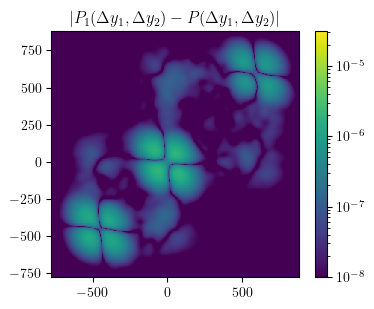

In [11]:
#plot the error of the joint P_1 in log scale
fig = plt.figure(figsize=(4,3.2))
ax = fig.add_subplot(111)

plt.title('$|P_1(\Delta y_1,\Delta y_2) - P(\Delta y_1,\Delta y_2)|$')

pcm = ax.pcolor(X, Y, np.abs(approx_pdf_track_res-track_PDF),
                norm=colors.LogNorm(vmax=10**(-4.5), vmin=10**(-8)))
plt.colorbar(pcm)
ax.set_facecolor('#440154FF')

plt.savefig("P_1Deltay_1,Deltay_2_error_all_log_6.png",
            format="png", bbox_inches="tight", dpi=1200)

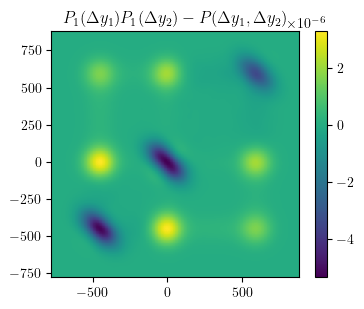

In [12]:
#plot the error of the product of the marginals P_1
fig = plt.figure(figsize=(4,3.2))
ax = fig.add_subplot(111)

plt.title('$P_1(\Delta y_1)P_1(\Delta y_2) - P(\Delta y_1,\Delta y_2)$')

pcm = ax.pcolor(X, Y, approx_pdf_ind_res-track_PDF)
plt.colorbar(pcm)
ax.set_facecolor('#440154FF')

plt.savefig("P_1Deltay_1_P_1Deltay_2_error_all_6.png",
            format="png", bbox_inches="tight", dpi=1200)

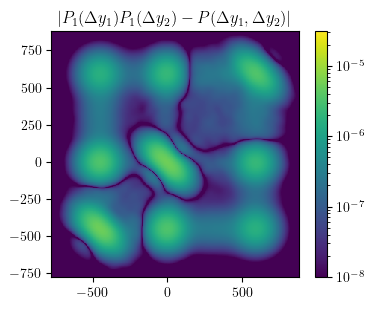

In [13]:
#plot the error of the product of the marginals P_1 in log scale
fig = plt.figure(figsize=(4,3.2))
ax = fig.add_subplot(111)

plt.title('$|P_1(\Delta y_1)P_1(\Delta y_2) - P(\Delta y_1,\Delta y_2)|$')

pcm = ax.pcolor(X, Y, np.abs(approx_pdf_ind_res-track_PDF),
                norm=colors.LogNorm(vmax=10**(-4.5), vmin=10**(-8)))
plt.colorbar(pcm)
ax.set_facecolor('#440154FF')

plt.savefig("P_1Deltay_1_P_1Deltay_2_error_all_log_6.png",
            format="png", bbox_inches="tight", dpi=1200)